In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score

- Women with ADHD penalized twice as much 
- Try graph neural net and convolutional neural net

In [124]:
def penalized_combination_f1(y_sex_true, y_adhd_true, sex_preds, adhd_preds):
    """
    Applies extra penalty to incorrect predictions of female ADHD cases.
    """
    # Identify the true and predicted "Female & ADHD" cases
    is_female_adhd_true = (y_sex_true == 1) & (y_adhd_true == 1)
    is_female_adhd_pred = (sex_preds == 1) & (adhd_preds == 1)

    weight = np.ones_like(y_sex_true)
    # Misclassified Female ADHD gets triple penalty
    weight[is_female_adhd_true & (is_female_adhd_pred == False)] = 3

    # Use this weight to compute F1 on ADHD prediction
    f1 = f1_score(y_adhd_true, adhd_preds, average="weighted", sample_weight=weight)
    return f1

### Load in the training data

In [85]:
# Use read_excel and use participant_id as the index
train_cat = pd.read_excel("../data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_func = pd.read_csv("../data/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
train_quant = pd.read_excel("../data/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
train_soln = pd.read_excel("../data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

In [86]:
display(train_cat.head(), train_func.head(), train_quant.head(), train_soln.head())

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.222930,0.527903,0.429966,0.060457,0.566489,0.315342,0.508408,-0.078290,0.525692,...,0.224985,0.397448,0.422966,0.184642,0.305549,0.420349,0.016328,0.561864,0.471170,0.365221
1,WHWymJu6zNZi,0.614765,0.577255,0.496127,0.496606,0.404686,0.439724,0.122590,-0.085452,0.120673,...,0.217546,-0.014549,0.000440,-0.096451,0.454501,0.343916,0.167313,0.607656,0.550623,0.503176
2,4PAQp1M6EyAo,-0.116833,0.458408,0.260703,0.639031,0.769337,0.442528,0.637110,0.192010,0.520379,...,0.342487,-0.021141,-0.037836,0.075069,0.412712,0.292708,0.391005,0.461544,0.508912,0.624232
3,obEacy4Of68I,0.199688,0.752714,0.658283,0.575096,0.692867,0.645789,0.522750,0.412188,0.530843,...,0.103562,-0.178313,0.210983,-0.018666,0.436313,0.592982,0.216205,0.341272,0.440313,0.558193
4,s7WzzDcmDOhF,0.227321,0.613268,0.621447,0.562673,0.736709,0.589813,0.266676,0.359668,0.300771,...,-0.164956,0.007064,-0.120904,-0.488095,0.493575,-0.215361,0.210685,0.055850,0.119065,0.108273


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


In [87]:
data_dict = pd.read_excel("../data/Data Dictionary.xlsx")
data_dict

,DataType,Instrument,Field,Description,Type,Labels
0,QUANTITATIVE METADATA,NaN,NaN,NaN,NaN,NaN
1,NaN,Identifier,participant_id,Participant ID,str,NaN
2,Quantitative,Edinburgh Handedness Questionnaire,EHQ_EHQ_Total,Laterality Index (Score),float,-100 = 10th left\n−28 ≤ LI < 48 = middle\n100 ...
3,Quantitative,Ishihara Color Vision Test,ColorVision_CV_Score,Color vision test score,int,NaN
4,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_CP,Corporal Punishment Score,int,NaN
5,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_ID,Inconsistent Discipline Score,int,NaN
6,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_INV,Involvement Score,int,NaN
7,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_OPD,Other Discipline Practices Score (Not factored...,int,NaN
8,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PM,Poor Monitoring/Supervision Score,int,NaN
9,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PP,Positive Parenting Score,int,NaN


## train_cat: One-hot encoding on the categorical values
1. Turn the numbers into their labels using the values provided in the data dictionary.
2. Use pandas to perform one-hot encoding so that the models can interpret the binary values instead of arbitrary numbers.

In [88]:
Basic_Demos_Study_Site = {
    1: "Staten Island",
    2: "MRV",
    3: "Midtown",
    4: "Harlem",
    5: "SI RUMC",
}

PreInt_Demos_Fam_Child_Ethnicity = {
    0: "Not Hispanic or Latino",
    1: "Hispanic or Latino",
    2: "Decline to specify",
    3: "Unknown"
}

PreInt_Demos_Fam_Child_Race = {
  0: "White/Caucasian",
  1: "Black/African American",
  2: "Hispanic",
  3: "Asian",
  4: "Indian",
  5: "Native American Indian",
  6: "American Indian/Alaskan Native",
  7: "Native Hawaiian/Other Pacific Islander",
  8: "Two or more races",
  9: "Other race",
  10: "Unknown",
  11: "Chose not to specify"}

MRI_Track_Scan_Location = {
    1: "Staten Island",
    2: "RUBIC", 
    3: "CBIC",
    4: "CUNY"
}

Barratt_Barratt_P1_Edu = {
    3: "Less than 7th grade",
    6: "Junior high/Middle school (9th grade)",
    9: "Partial high school (10th or 11th grade)",
    12: "High school graduate",
    15: "Partial college (at least one year)",
    18: "College education",
    21: "Graduate degree"
}

Barratt_Barratt_P1_Occ = {
    0: "Homemaker, stay at home parent.",
    5: "Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.",
    10: "Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.",
    15: "Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.",
    20: "Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser.",
    25: "Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.",
    30: "Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",
    35: "Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.",
    40: "Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.",
    45: "Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant."
}

Barratt_Barratt_P2_Edu = {
    3: "Less than 7th grade",
    6: "Junior high/Middle school (9th grade)",
    9: "Partial high school (10th or 11th grade)",
    12: "High school graduate",
    15: "Partial college (at least one year)",
    18: "College education",
    21: "Graduate degree"
}

Barratt_Barratt_P2_Occ = {
    0: "Homemaker, stay at home parent.",
    5: "Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.",
    10: "Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.",
    15: "Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.",
    20: "Automobile mechanic, typist, locksmith, farmer, carpenter, receptionist, construction laborer, hairdresser.",
    25: "Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.",
    30: "Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",
    35: "Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.",
    40: "Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.",
    45: "Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.",
}



In [89]:
# Apply label replacements using the dictionaries
train_cat["Basic_Demos_Study_Site"] = train_cat["Basic_Demos_Study_Site"].replace(
    Basic_Demos_Study_Site
)
train_cat["PreInt_Demos_Fam_Child_Ethnicity"] = train_cat[
    "PreInt_Demos_Fam_Child_Ethnicity"
].replace(PreInt_Demos_Fam_Child_Ethnicity)
train_cat["PreInt_Demos_Fam_Child_Race"] = train_cat[
    "PreInt_Demos_Fam_Child_Race"
].replace(PreInt_Demos_Fam_Child_Race)
train_cat["MRI_Track_Scan_Location"] = train_cat["MRI_Track_Scan_Location"].replace(
    MRI_Track_Scan_Location
)
train_cat["Barratt_Barratt_P1_Edu"] = train_cat["Barratt_Barratt_P1_Edu"].replace(
    Barratt_Barratt_P1_Edu
)
train_cat["Barratt_Barratt_P1_Occ"] = train_cat["Barratt_Barratt_P1_Occ"].replace(
    Barratt_Barratt_P1_Occ
)
train_cat["Barratt_Barratt_P2_Edu"] = train_cat["Barratt_Barratt_P2_Edu"].replace(
    Barratt_Barratt_P2_Edu
)
train_cat["Barratt_Barratt_P2_Occ"] = train_cat["Barratt_Barratt_P2_Occ"].replace(
    Barratt_Barratt_P2_Occ
)

In [90]:
# One-hot encode all columns except 'participant_id' and 'Basic_Demos_Enroll_Year'
train_cat_encoded = pd.get_dummies(
    train_cat,
    columns=[
        "Basic_Demos_Study_Site",
        "PreInt_Demos_Fam_Child_Ethnicity",
        "PreInt_Demos_Fam_Child_Race",
        "MRI_Track_Scan_Location",
        "Barratt_Barratt_P1_Edu",
        "Barratt_Barratt_P1_Occ",
        "Barratt_Barratt_P2_Edu",
        "Barratt_Barratt_P2_Occ",
    ],
    dummy_na=True,  # Optional: adds a column for NaNs if present
    drop_first=False,  # Set to True if you want to drop the first category to avoid multicollinearity
)

# Check the result
train_cat_encoded.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site_Harlem,Basic_Demos_Study_Site_MRV,Basic_Demos_Study_Site_Midtown,Basic_Demos_Study_Site_Staten Island,Basic_Demos_Study_Site_nan,PreInt_Demos_Fam_Child_Ethnicity_Decline to specify,PreInt_Demos_Fam_Child_Ethnicity_Hispanic or Latino,PreInt_Demos_Fam_Child_Ethnicity_Not Hispanic or Latino,...,"Barratt_Barratt_P2_Occ_Day laborer, janitor, house cleaner, farm worker, food counter sales, food preparation worker, busboy.","Barratt_Barratt_P2_Occ_Garbage collector, short-order cook, cab driver, shoe sales, assembly line workers, masons, baggage porter.","Barratt_Barratt_P2_Occ_Homemaker, stay at home parent.","Barratt_Barratt_P2_Occ_Machinist, musician, bookkeeper, secretary, insurance sales, cabinet maker, personnel specialist, welder.","Barratt_Barratt_P2_Occ_Mechanical, nuclear, and electrical engineer, educational administrator, veterinarian, military officer, elementary, high school and special education teacher.","Barratt_Barratt_P2_Occ_Nurse, skilled technician, medical technician, counselor, manager, police and fire personnel, financial manager, physical, occupational, speech therapist.","Barratt_Barratt_P2_Occ_Painter, skilled construction trade, sales clerk, truck driver, cook, sales counter or general office clerk.","Barratt_Barratt_P2_Occ_Physician, attorney, professor, chemical and aerospace engineer, judge, CEO, senior manager, public official, psychologist, pharmacist, accountant.","Barratt_Barratt_P2_Occ_Supervisor, librarian, aircraft mechanic, artist and artisan, electrician, administrator, military enlisted personnel, buyer.",Barratt_Barratt_P2_Occ_nan
0,00aIpNTbG5uh,2019,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,00fV0OyyoLfw,2017,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2,04X1eiS79T4B,2017,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,05ocQutkURd6,2018,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,06YUNBA9ZRLq,2018,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


## train_func: reduce the dimensionality of the functional MRI connectome matrix

Original shape: (1213, 19900)
Transformed shape: (1213, 464)


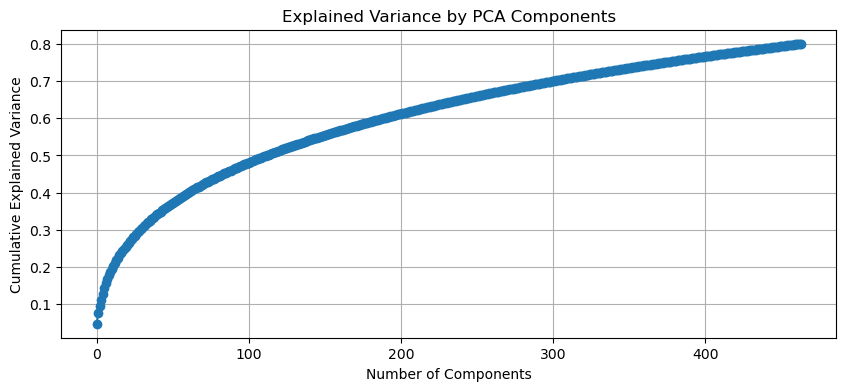

In [91]:
# Separate the features (connectome matrix) from the participant IDs
X = train_func.drop(columns=["participant_id"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Want to capture 75% of the variance
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X_scaled)

# Shape of the transformed data
print("Original shape:", X_scaled.shape)
print("Transformed shape:", X_pca.shape)

# Explained variance
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

In [92]:
train_func_pca = pd.DataFrame(
    X_pca,
    index=train_func["participant_id"],
    columns=[f"fmri_pca_{i+1}" for i in range(X_pca.shape[1])],
)
train_func_pca.head()

,fmri_pca_1,fmri_pca_2,fmri_pca_3,fmri_pca_4,fmri_pca_5,fmri_pca_6,fmri_pca_7,fmri_pca_8,fmri_pca_9,fmri_pca_10,...,fmri_pca_455,fmri_pca_456,fmri_pca_457,fmri_pca_458,fmri_pca_459,fmri_pca_460,fmri_pca_461,fmri_pca_462,fmri_pca_463,fmri_pca_464
participant_id,,,,,,,,,,,,,,,,,,,,,
70z8Q2xdTXM3,35.753597,0.090543,-20.350098,-19.088315,-30.805000,2.306746,0.012355,-16.080110,-6.713655,7.132238,...,2.444320,2.246306,-0.601253,-0.318204,-2.567000,-4.188951,-0.423559,2.751428,1.282703,-4.683491
WHWymJu6zNZi,28.459455,-18.887916,10.232790,-1.115161,-7.235638,-14.893705,5.991655,-3.274425,-18.623446,-12.154646,...,0.823866,-3.250062,-5.154873,4.001859,1.863844,-1.724962,3.029928,1.894485,0.494266,-5.851479
4PAQp1M6EyAo,0.798687,4.718468,10.989505,17.687384,10.643912,31.792714,-9.804087,16.585635,-15.010728,-8.778202,...,-5.095345,-3.494166,1.078176,-0.983331,-4.876152,-3.644965,-1.572020,-0.539341,-1.401308,0.602506
obEacy4Of68I,-45.767171,-11.453186,4.095472,-12.695696,-20.976370,22.331782,4.630708,-4.709863,0.145218,10.252135,...,-8.181315,3.897831,0.253571,0.590245,-0.110259,0.937680,-0.855990,5.276611,-3.118190,2.629994
s7WzzDcmDOhF,3.746646,-8.847485,10.058838,2.305610,-3.341812,14.484016,28.106098,5.519340,-6.920033,4.655665,...,3.944539,-2.646924,1.673610,3.358918,1.923088,-0.500143,1.875633,0.253948,-0.448169,4.047551


In [93]:
# Deal with NaN values
train_quant = train_quant.fillna(
    train_quant.drop("participant_id", axis=1).mean()
)
train_quant.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,11.245678
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


### Make one input matrix X by merging on participant_id
Currently, the dataframes are:
- train_cat_encoded (one-hot encoded so all binary)
- train_func_pca (reduced to 374 PCs)
- train_quant (dealt with NaN values)
- they all have 1213 rows, so the merging shouldn't lose any data
- they all have the participant_id column, which will uniquely merge each row

In [94]:
# cat_func_merge = pd.merge(train_cat_encoded, train_func_pca, how='outer', on="participant_id")
# X_with_id = pd.merge(cat_func_merge, train_quant, how="outer", on="participant_id")
# X = X_with_id.drop("participant_id", axis=1)
# # Turn boolean columns into integers (0/1)
# X = X.astype({col: int for col in X.select_dtypes("bool").columns})
# X.head()

In [95]:
cat_func_merge = pd.merge(
    train_cat_encoded, train_func, how="outer", on="participant_id"
)
X_with_id = pd.merge(cat_func_merge, train_quant, how="outer", on="participant_id")
X = X_with_id.drop("participant_id", axis=1)
# Turn boolean columns into integers (0/1)
X = X.astype({col: int for col in X.select_dtypes("bool").columns})
X.head()

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site_Harlem,Basic_Demos_Study_Site_MRV,Basic_Demos_Study_Site_Midtown,Basic_Demos_Study_Site_Staten Island,Basic_Demos_Study_Site_nan,PreInt_Demos_Fam_Child_Ethnicity_Decline to specify,PreInt_Demos_Fam_Child_Ethnicity_Hispanic or Latino,PreInt_Demos_Fam_Child_Ethnicity_Not Hispanic or Latino,PreInt_Demos_Fam_Child_Ethnicity_Unknown,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,2019,1,0,0,0,0,0,1,0,0,...,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,2017,0,0,0,1,0,0,0,1,0,...,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,11.245678
2,2017,0,0,0,1,0,0,1,0,0,...,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,2018,0,0,0,1,0,0,0,0,1,...,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,2018,0,0,0,1,0,0,0,1,0,...,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [96]:
y_sex = train_soln["Sex_F"]  
y_adhd = train_soln["ADHD_Outcome"] 

In [97]:
train_soln.head()

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


## Model 1: Neural Net

#### First, build a NN just for classifying sex

In [98]:
# Split into train and validation using y_sex
X_train, X_val, y_train_sex, y_val_sex, y_train_adhd, y_val_adhd = train_test_split(
    X, y_sex, y_adhd, test_size=0.2, random_state=42
)

In [99]:
# Scale inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [100]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_train_tensor = X_train_tensor.to("cpu")
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)

y_train_tensor_sex = torch.tensor(y_train_sex.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor_sex = torch.tensor(y_val_sex.values, dtype=torch.float32).unsqueeze(1)

y_train_tensor_adhd = torch.tensor(y_train_adhd.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor_adhd = torch.tensor(y_val_adhd.values, dtype=torch.float32).unsqueeze(1)

In [101]:
from sklearn.utils.class_weight import compute_class_weight
import torch

class_weights_sex = compute_class_weight(
    class_weight="balanced", classes=[0, 1], y=y_train_tensor_sex.numpy().flatten()
)
# Convert to tensor
class_weights_sex = torch.tensor(class_weights_sex)


class_weights_adhd = compute_class_weight(
    class_weight="balanced", classes=[0, 1], y=y_train_tensor_adhd.numpy().flatten()
)

# Convert to tensor
class_weights_adhd = torch.tensor(class_weights_adhd)

In [102]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

Epoch [0/50] - Train Loss: 0.7986 - Val Loss: 0.7633 - Train Accuracy: 0.6443 - Train F1: 0.0000 - Train Recall: 0.0000 - Val Accuracy: 0.5720 - Val F1: 0.3158 - Val Recall: 0.3333
Epoch [5/50] - Train Loss: 0.4760 - Val Loss: 0.7973 - Train Accuracy: 0.8320 - Train F1: 0.7323 - Train Recall: 0.6483 - Val Accuracy: 0.5967 - Val F1: 0.3194 - Val Recall: 0.3194
Epoch [10/50] - Train Loss: 0.2595 - Val Loss: 0.9751 - Train Accuracy: 0.9124 - Train F1: 0.8718 - Train Recall: 0.8401 - Val Accuracy: 0.6049 - Val F1: 0.2836 - Val Recall: 0.2639
Epoch [15/50] - Train Loss: 0.1224 - Val Loss: 1.3534 - Train Accuracy: 0.9619 - Train F1: 0.9450 - Train Recall: 0.9244 - Val Accuracy: 0.6173 - Val F1: 0.2901 - Val Recall: 0.2639
Epoch [20/50] - Train Loss: 0.0527 - Val Loss: 1.7239 - Train Accuracy: 0.9856 - Train F1: 0.9794 - Train Recall: 0.9680 - Val Accuracy: 0.6132 - Val F1: 0.2985 - Val Recall: 0.2778
Epoch [25/50] - Train Loss: 0.0294 - Val Loss: 2.1175 - Train Accuracy: 0.9948 - Train F1: 0

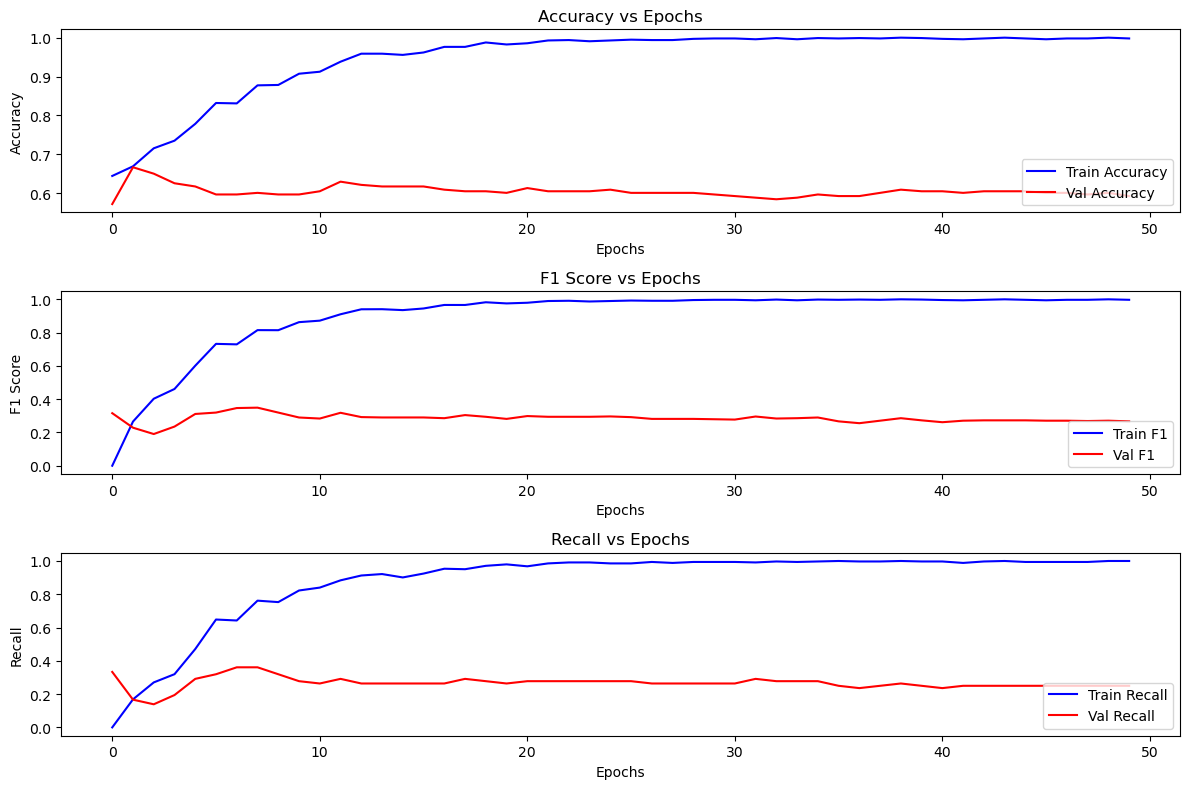

In [103]:
# Instantiate model
model_sex = SimpleNN(input_dim=X_train.shape[1])

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(
    pos_weight=class_weights_sex[1]
)  # weight for the minority class

# criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
optimizer = torch.optim.Adam(model_sex.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize lists to store metrics
train_acc_list = []
train_f1_list = []
train_recall_list = []
val_acc_list = []
val_f1_list = []
val_recall_list = []

# Training loop for sex classification
n_epochs = 50
for epoch in range(n_epochs):
    model_sex.train()

    # Forward pass
    outputs = model_sex(X_train_tensor)
    loss = criterion(outputs, y_train_tensor_sex)

    # Apply threshold to get binary predictions
    preds_train = (outputs > 0.5).float()

    # Compute metrics for training
    train_acc = accuracy_score(y_train_tensor_sex.numpy(), preds_train.numpy())
    train_f1 = f1_score(y_train_tensor_sex.numpy(), preds_train.numpy())
    train_recall = recall_score(y_train_tensor_sex.numpy(), preds_train.numpy())

    # Append metrics to lists
    train_acc_list.append(train_acc)
    train_f1_list.append(train_f1)
    train_recall_list.append(train_recall)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model_sex.eval()
    with torch.no_grad():
        outputs = model_sex(X_val_tensor)
        val_loss = criterion(
            outputs, y_val_tensor_sex
        )  # <--- add this line to compute validation loss
        preds = torch.sigmoid(outputs)
        preds_val = (preds > 0.5).float()

        # Compute metrics for validation
        val_acc = accuracy_score(y_val_tensor_sex.numpy(), preds_val.numpy())
        val_f1 = f1_score(y_val_tensor_sex.numpy(), preds_val.numpy())
        val_recall = recall_score(y_val_tensor_sex.numpy(), preds_val.numpy())

        # Append validation metrics to lists
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)
        val_recall_list.append(val_recall)

    if epoch % 5 == 0:
        print(
            f"Epoch [{epoch}/{n_epochs}] - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f} "
            f"- Train Accuracy: {train_acc:.4f} - Train F1: {train_f1:.4f} - Train Recall: {train_recall:.4f} "
            f"- Val Accuracy: {val_acc:.4f} - Val F1: {val_f1:.4f} - Val Recall: {val_recall:.4f}"
        )


# Plotting the metrics
epochs = list(range(n_epochs))
plt.figure(figsize=(12, 8))

# Plot accuracy
plt.subplot(3, 1, 1)
plt.plot(epochs, train_acc_list, label="Train Accuracy", color="b")
plt.plot(epochs, val_acc_list, label="Val Accuracy", color="r")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy vs Epochs")

# Plot F1 score
plt.subplot(3, 1, 2)
plt.plot(epochs, train_f1_list, label="Train F1", color="b")
plt.plot(epochs, val_f1_list, label="Val F1", color="r")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend(loc="lower right")
plt.title("F1 Score vs Epochs")

# Plot recall
plt.subplot(3, 1, 3)
plt.plot(epochs, train_recall_list, label="Train Recall", color="b")
plt.plot(epochs, val_recall_list, label="Val Recall", color="r")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(loc="lower right")
plt.title("Recall vs Epochs")

plt.tight_layout()
plt.show()

Epoch [0/50] - Train Loss: 0.9532 - Val Loss: 0.8923 - Train Accuracy: 0.3278 - Train F1: 0.0031 - Train Recall: 0.0015 - Val Accuracy: 0.6255 - Val F1: 0.7547 - Val Recall: 0.7865
Epoch [5/50] - Train Loss: 0.5650 - Val Loss: 0.7536 - Train Accuracy: 0.7742 - Train F1: 0.8493 - Train Recall: 0.9449 - Val Accuracy: 0.7243 - Val F1: 0.8393 - Val Recall: 0.9831
Epoch [10/50] - Train Loss: 0.3302 - Val Loss: 0.8816 - Train Accuracy: 0.9031 - Train F1: 0.9287 - Train Recall: 0.9372 - Val Accuracy: 0.6626 - Val F1: 0.7897 - Val Recall: 0.8652
Epoch [15/50] - Train Loss: 0.1872 - Val Loss: 1.0897 - Train Accuracy: 0.9515 - Train F1: 0.9642 - Train Recall: 0.9694 - Val Accuracy: 0.6502 - Val F1: 0.7804 - Val Recall: 0.8483
Epoch [20/50] - Train Loss: 0.0957 - Val Loss: 1.3513 - Train Accuracy: 0.9794 - Train F1: 0.9846 - Train Recall: 0.9816 - Val Accuracy: 0.6626 - Val F1: 0.7865 - Val Recall: 0.8483
Epoch [25/50] - Train Loss: 0.0462 - Val Loss: 1.6646 - Train Accuracy: 0.9907 - Train F1: 0

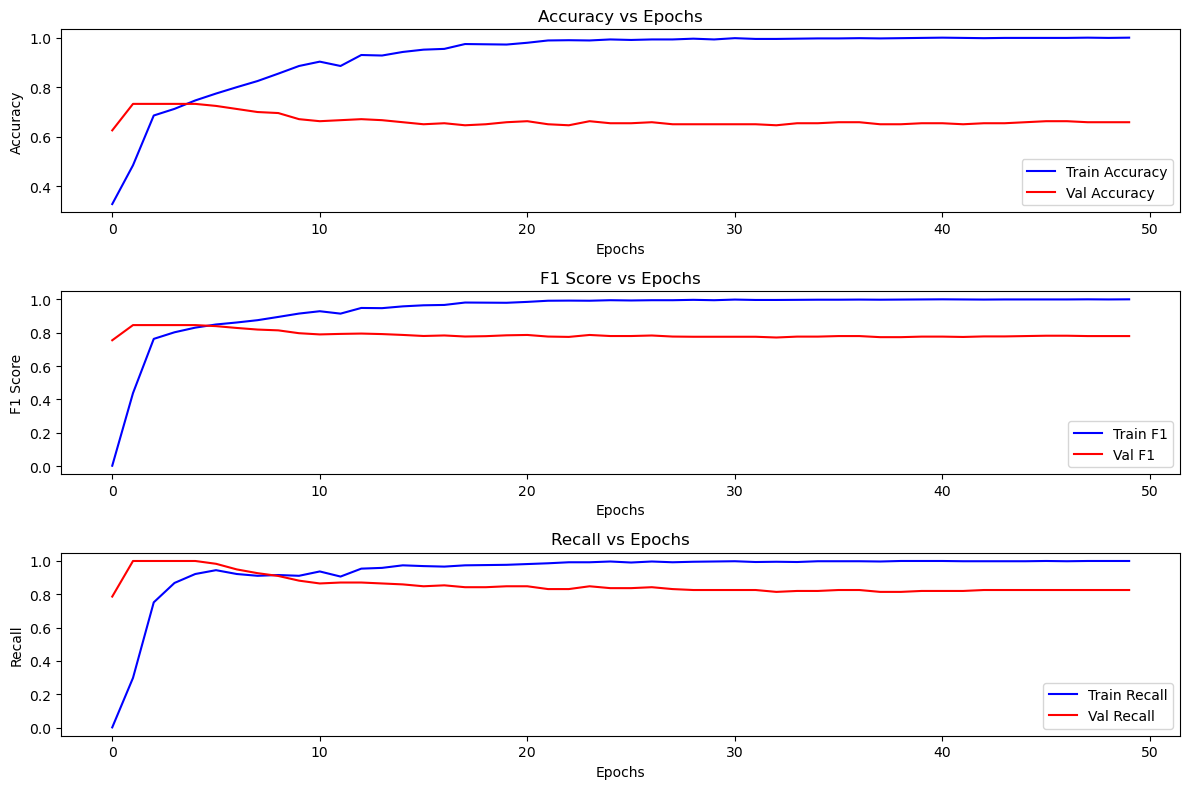

In [104]:
# Instantiate model
model_adhd = SimpleNN(input_dim=X_train.shape[1])

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(
    pos_weight=class_weights_adhd[0]
)  # weight for the minority class

# criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
optimizer = torch.optim.Adam(model_adhd.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize lists to store metrics
train_acc_list = []
train_f1_list = []
train_recall_list = []
val_acc_list = []
val_f1_list = []
val_recall_list = []

# Training loop for ADHD classification
n_epochs = 50
for epoch in range(n_epochs):
    model_adhd.train()

    # Forward pass
    outputs = model_adhd(X_train_tensor)
    loss = criterion(outputs, y_train_tensor_adhd)

    # Apply threshold to get binary predictions
    preds_train = (outputs > 0.5).float()

    # Compute metrics for training
    train_acc = accuracy_score(y_train_tensor_adhd.numpy(), preds_train.numpy())
    train_f1 = f1_score(y_train_tensor_adhd.numpy(), preds_train.numpy())
    train_recall = recall_score(y_train_tensor_adhd.numpy(), preds_train.numpy())

    # Append metrics to lists
    train_acc_list.append(train_acc)
    train_f1_list.append(train_f1)
    train_recall_list.append(train_recall)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model_adhd.eval()
    with torch.no_grad():
        outputs = model_adhd(X_val_tensor)
        val_loss = criterion(
            outputs, y_val_tensor_adhd
        )  # <--- add this line to compute validation loss
        preds = torch.sigmoid(outputs)
        preds_val = (preds > 0.5).float()

        # Compute metrics for validation
        val_acc = accuracy_score(y_val_tensor_adhd.numpy(), preds_val.numpy())
        val_f1 = f1_score(y_val_tensor_adhd.numpy(), preds_val.numpy())
        val_recall = recall_score(y_val_tensor_adhd.numpy(), preds_val.numpy())

        # Append validation metrics to lists
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)
        val_recall_list.append(val_recall)

    if epoch % 5 == 0:
        print(
            f"Epoch [{epoch}/{n_epochs}] - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f} "
            f"- Train Accuracy: {train_acc:.4f} - Train F1: {train_f1:.4f} - Train Recall: {train_recall:.4f} "
            f"- Val Accuracy: {val_acc:.4f} - Val F1: {val_f1:.4f} - Val Recall: {val_recall:.4f}"
        )


# Plotting the metrics
epochs = list(range(n_epochs))
plt.figure(figsize=(12, 8))

# Plot accuracy
plt.subplot(3, 1, 1)
plt.plot(epochs, train_acc_list, label="Train Accuracy", color="b")
plt.plot(epochs, val_acc_list, label="Val Accuracy", color="r")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy vs Epochs")

# Plot F1 score
plt.subplot(3, 1, 2)
plt.plot(epochs, train_f1_list, label="Train F1", color="b")
plt.plot(epochs, val_f1_list, label="Val F1", color="r")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend(loc="lower right")
plt.title("F1 Score vs Epochs")

# Plot recall
plt.subplot(3, 1, 3)
plt.plot(epochs, train_recall_list, label="Train Recall", color="b")
plt.plot(epochs, val_recall_list, label="Val Recall", color="r")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(loc="lower right")
plt.title("Recall vs Epochs")

plt.tight_layout()
plt.show()

In [105]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score, f1_score


# # Helper: Calculate custom F1 based on thresholded outputs
# def compute_custom_f1(y_true, y_pred_logits):
#     preds = (torch.sigmoid(y_pred_logits) > 0.5).float()
#     return f1_score(y_true.numpy(), preds.numpy())


# # Define models
# model_sex = SimpleNN(input_dim=X_train.shape[1])
# model_adhd = SimpleNN(input_dim=X_train.shape[1])

# # Loss functions
# criterion_sex = nn.BCEWithLogitsLoss(pos_weight=class_weights_sex[1])
# criterion_adhd = nn.BCEWithLogitsLoss(pos_weight=class_weights_adhd[1])

# # Optimizers
# optimizer_sex = optim.Adam(model_sex.parameters(), lr=0.01, weight_decay=1e-5)
# optimizer_adhd = optim.Adam(model_adhd.parameters(), lr=0.01, weight_decay=1e-5)

# # Training settings
# n_epochs = 50
# early_stop_patience = 7

# # Trackers
# metrics = {
#     "train_acc_sex": [],
#     "val_acc_sex": [],
#     "train_f1_sex": [],
#     "val_f1_sex": [],
#     "train_acc_adhd": [],
#     "val_acc_adhd": [],
#     "train_f1_adhd": [],
#     "val_f1_adhd": [],
# }

# best_val_f1 = 0
# epochs_no_improve = 0

# for epoch in range(n_epochs):
#     model_sex.train()
#     model_adhd.train()

#     # --- SEX model ---
#     outputs_sex = model_sex(X_train_tensor)
#     loss_sex = criterion_sex(outputs_sex, y_train_tensor_sex) + soft_f1_loss(
#         y_train_tensor_sex, outputs_sex
#     )

#     optimizer_sex.zero_grad()
#     loss_sex.backward()
#     optimizer_sex.step()

#     preds_sex_train = (torch.sigmoid(outputs_sex) > 0.5).float()

#     # --- ADHD model ---
#     outputs_adhd = model_adhd(X_train_tensor)
#     loss_adhd = criterion_adhd(outputs_adhd, y_train_tensor_adhd) + soft_f1_loss(
#         y_train_tensor_adhd, outputs_adhd
#     )

#     optimizer_adhd.zero_grad()
#     loss_adhd.backward()
#     optimizer_adhd.step()

#     preds_adhd_train = (torch.sigmoid(outputs_adhd) > 0.5).float()

#     # Evaluate
#     model_sex.eval()
#     model_adhd.eval()
#     with torch.no_grad():
#         outputs_sex_val = model_sex(X_val_tensor)
#         preds_sex_val = (torch.sigmoid(outputs_sex_val) > 0.5).float()

#         outputs_adhd_val = model_adhd(X_val_tensor)
#         preds_adhd_val = (torch.sigmoid(outputs_adhd_val) > 0.5).float()

#         # Track SEX metrics
#         metrics["train_acc_sex"].append(
#             accuracy_score(y_train_tensor_sex.numpy(), preds_sex_train.numpy())
#         )
#         metrics["val_acc_sex"].append(
#             accuracy_score(y_val_tensor_sex.numpy(), preds_sex_val.numpy())
#         )
#         metrics["train_f1_sex"].append(
#             f1_score(y_train_tensor_sex.numpy(), preds_sex_train.numpy())
#         )
#         metrics["val_f1_sex"].append(
#             f1_score(y_val_tensor_sex.numpy(), preds_sex_val.numpy())
#         )

#         # Track ADHD metrics
#         metrics["train_acc_adhd"].append(
#             accuracy_score(y_train_tensor_adhd.numpy(), preds_adhd_train.numpy())
#         )
#         metrics["val_acc_adhd"].append(
#             accuracy_score(y_val_tensor_adhd.numpy(), preds_adhd_val.numpy())
#         )
#         metrics["train_f1_adhd"].append(
#             f1_score(y_train_tensor_adhd.numpy(), preds_adhd_train.numpy())
#         )
#         metrics["val_f1_adhd"].append(
#             f1_score(y_val_tensor_adhd.numpy(), preds_adhd_val.numpy())
#         )

#     # --- Early stopping ---
#     avg_val_f1 = (metrics["val_f1_sex"][-1] + metrics["val_f1_adhd"][-1]) / 2
#     if avg_val_f1 > best_val_f1:
#         best_val_f1 = avg_val_f1
#         epochs_no_improve = 0
#     else:
#         epochs_no_improve += 1

#     if epochs_no_improve >= early_stop_patience:
#         print(f"Early stopping at epoch {epoch}")
#         break

#     # Print progress
#     if epoch % 5 == 0 or epoch == n_epochs - 1:
#         print(
#             f"[Epoch {epoch}] "
#             f"Sex F1 (train/val): {metrics['train_f1_sex'][-1]:.4f}/{metrics['val_f1_sex'][-1]:.4f} | "
#             f"ADHD F1 (train/val): {metrics['train_f1_adhd'][-1]:.4f}/{metrics['val_f1_adhd'][-1]:.4f}"
#         )

# # --- Plotting ---

# fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# # Accuracy plots
# axs[0, 0].plot(metrics["train_acc_sex"], label="Train Accuracy (Sex)")
# axs[0, 0].plot(metrics["val_acc_sex"], label="Val Accuracy (Sex)")
# axs[0, 0].set_title("Sex Model Accuracy")
# axs[0, 0].legend()

# axs[0, 1].plot(metrics["train_acc_adhd"], label="Train Accuracy (ADHD)")
# axs[0, 1].plot(metrics["val_acc_adhd"], label="Val Accuracy (ADHD)")
# axs[0, 1].set_title("ADHD Model Accuracy")
# axs[0, 1].legend()

# # F1 Score plots
# axs[1, 0].plot(metrics["train_f1_sex"], label="Train F1 (Sex)")
# axs[1, 0].plot(metrics["val_f1_sex"], label="Val F1 (Sex)")
# axs[1, 0].set_title("Sex Model F1 Score")
# axs[1, 0].legend()

# axs[1, 1].plot(metrics["train_f1_adhd"], label="Train F1 (ADHD)")
# axs[1, 1].plot(metrics["val_f1_adhd"], label="Val F1 (ADHD)")
# axs[1, 1].set_title("ADHD Model F1 Score")
# axs[1, 1].legend()

# plt.tight_layout()
# plt.show()

## Get our submission files

In [106]:
# Load the testing data
test_cat = pd.read_excel("../data/TEST/TEST_CATEGORICAL.xlsx")
test_func = pd.read_csv("../data/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
test_quant = pd.read_excel("../data/TEST/TEST_QUANTITATIVE_METADATA.xlsx")

In [107]:
test_func

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,0.548480,0.713607,0.557319,0.524369,0.693364,0.770032,0.724406,0.390118,0.547912,...,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,0.427740,0.363022,0.402862,0.363003,0.534558,0.345347,0.409471,0.303328,0.402515,...,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,0.139572,0.390106,-0.087041,0.196852,0.088148,0.023843,0.381782,0.068979,0.377488,...,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987
3,LZfeAb1xMtql,0.133561,0.778326,0.416355,0.471840,0.568460,0.633660,0.501113,0.345461,0.467943,...,0.046183,-0.238962,0.121868,-0.260970,0.646818,0.594902,0.608156,0.595459,0.683189,0.542296
4,EnFOUv0YK1RG,0.126699,0.575446,0.509422,0.363193,0.427544,0.449924,0.451796,0.223927,0.298248,...,0.315734,0.002234,0.290791,0.344149,0.480214,0.539824,0.447322,0.293088,0.148529,0.539823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,UadZfjdEg7eG,0.029721,0.596742,0.361898,0.292066,0.553130,0.476284,0.543970,0.372932,0.595183,...,0.021524,-0.162832,0.105546,0.028975,0.576180,0.378365,0.399277,0.556115,0.490833,0.568742
300,IUEHiLmQAqCi,0.025985,0.347840,0.304804,0.463090,0.305321,0.267397,0.468712,0.155677,0.298155,...,0.044974,-0.078047,-0.118271,0.035741,0.640073,0.515096,0.206462,0.536001,0.318518,0.305596
301,cRySmCadYFRO,0.105385,0.443624,-0.019777,0.435582,0.376492,0.619322,0.430177,0.567600,0.399820,...,0.145582,0.004455,0.134574,-0.152951,0.782938,0.737555,0.593972,0.734463,0.680979,0.678973
302,E3MvDUtJadc5,0.345641,0.758986,0.748153,0.442141,0.571924,0.485011,0.530513,0.137672,0.467144,...,0.036169,-0.345563,-0.165280,-0.347035,0.657024,0.590523,0.094565,0.727339,0.429694,0.530238


In [108]:
# Apply label replacements for the test data (same as for training data)
test_cat["Basic_Demos_Study_Site"] = test_cat["Basic_Demos_Study_Site"].replace(
    Basic_Demos_Study_Site
)
test_cat["PreInt_Demos_Fam_Child_Ethnicity"] = test_cat[
    "PreInt_Demos_Fam_Child_Ethnicity"
].replace(PreInt_Demos_Fam_Child_Ethnicity)
test_cat["PreInt_Demos_Fam_Child_Race"] = test_cat[
    "PreInt_Demos_Fam_Child_Race"
].replace(PreInt_Demos_Fam_Child_Race)
test_cat["MRI_Track_Scan_Location"] = test_cat["MRI_Track_Scan_Location"].replace(
    MRI_Track_Scan_Location
)
test_cat["Barratt_Barratt_P1_Edu"] = test_cat["Barratt_Barratt_P1_Edu"].replace(
    Barratt_Barratt_P1_Edu
)
test_cat["Barratt_Barratt_P1_Occ"] = test_cat["Barratt_Barratt_P1_Occ"].replace(
    Barratt_Barratt_P1_Occ
)
test_cat["Barratt_Barratt_P2_Edu"] = test_cat["Barratt_Barratt_P2_Edu"].replace(
    Barratt_Barratt_P2_Edu
)
test_cat["Barratt_Barratt_P2_Occ"] = test_cat["Barratt_Barratt_P2_Occ"].replace(
    Barratt_Barratt_P2_Occ
)

# One-hot encode the categorical columns for test data
test_cat_encoded = pd.get_dummies(
    test_cat,
    columns=[
        "Basic_Demos_Study_Site",
        "PreInt_Demos_Fam_Child_Ethnicity",
        "PreInt_Demos_Fam_Child_Race",
        "MRI_Track_Scan_Location",
        "Barratt_Barratt_P1_Edu",
        "Barratt_Barratt_P1_Occ",
        "Barratt_Barratt_P2_Edu",
        "Barratt_Barratt_P2_Occ",
    ],
    dummy_na=True,
    drop_first=False,
)

In [111]:
# Ensure 'participant_id' is kept for merging later
test_participant_ids = test_func["participant_id"]
test_func = test_func.drop(columns=["participant_id"])

In [113]:
scaler = StandardScaler()

# Fit the scaler on the training data (train_func) first
scaler.fit(train_func.drop(columns=["participant_id"]))
X_test_scaled = scaler.transform(test_func)

In [114]:
# PCA transformation (fit on training data, then apply to test data)
# Make sure to initialize the PCA model before using it for transformation
pca = PCA(n_components=0.80)
pca.fit(X_scaled)

# Fit the PCA on the training data (train_func_scaled) and transform the test data
X_test_pca = pca.transform(X_test_scaled)

# Convert PCA data to DataFrame with participant_id as the index
test_func_pca = pd.DataFrame(
    X_test_pca,
    index=test_participant_ids,  # Use the original participant_id from test_func
    columns=[f"fmri_pca_{i+1}" for i in range(X_test_pca.shape[1])],
)

In [115]:
# Handle missing values in quantitative data (fill NaNs with the column means)
test_quant = test_quant.fillna(test_quant.drop("participant_id", axis=1).mean())

In [ ]:
# # Merge the encoded categorical, PCA features, and quantitative data for the test set
# test_data_merged = pd.merge(
#     test_cat_encoded, test_func_pca, how="outer", on="participant_id"
# )
# X_test = pd.merge(test_data_merged, test_quant, how="outer", on="participant_id")
# X_test_has_ids = X_test.drop("participant_id", axis=1)
# X_test = X_test_has_ids.astype({col: int for col in X_test.select_dtypes("bool").columns})

In [117]:
test_func_id = pd.DataFrame(
    test_func,
    index=test_participant_ids,  # Use the original participant_id from test_func
    columns=[f"fmri_pca_{i+1}" for i in range(test_func.shape[1])],
)

In [120]:
test_data_merged = pd.merge(
    test_cat_encoded, test_func_id, how="outer", on="participant_id"
)

X_test_has_ids = pd.merge(test_data_merged, test_quant, how="outer", on="participant_id")
X_test = X_test_has_ids.drop(columns=["participant_id"])
X_test = X_test.astype(
    {col: int for col in X_test.select_dtypes("bool").columns}
)

In [121]:
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

In [122]:
# Step 1: Convert X_test to tensor
X_test_tensor = torch.from_numpy(X_test.values).float()

# Step 2: Set model to eval mode
model_sex.eval()
model_adhd.eval()

# Step 3: Predict
with torch.no_grad():
    outputs_sex = model_sex(X_test_tensor)
    outputs_adhd = model_adhd(X_test_tensor)

    preds_sex = torch.sigmoid(outputs_sex)
    preds_adhd = torch.sigmoid(outputs_adhd)

    # Apply 0.5 threshold
    y_pred_test_sex = (preds_sex > 0.5).int().squeeze().numpy()
    y_pred_test_adhd = (preds_adhd > 0.5).int().squeeze().numpy()


submission_df = pd.DataFrame(
    {
        "ADHD_Outcome": y_pred_test_adhd,
        "Sex_F": y_pred_test_sex,
    },
    index=test_participant_ids,  # <- if you want participant_id as index
)

submission_df.index.name = "participant_id"  # Make sure the index has a name

submission_df.to_csv("submission_nn.csv", index=True)

print(submission_df.head())

                ADHD_Outcome  Sex_F
participant_id                     
Cfwaf5FX7jWK               1      0
vhGrzmvA3Hjq               1      0
ULliyEXjy4OV               1      0
LZfeAb1xMtql               1      0
EnFOUv0YK1RG               1      0
